In [1]:
import findspark
findspark.init() 

In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType,BooleanType,DateType,FloatType, StringType
import matplotlib.pyplot as plt 
import seaborn as sns
import pyspark.sql.types as T


In [4]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

def fudf(val):
    return functools.reduce(lambda x, y:x+y, val)

In [77]:
df = spark.read.json('C:\\Users\\pasqu\\Desktop\\Università\\Distributed Data Analysis and Mining\\cleaned_dataset')

In [78]:
df.show()

+------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+------------+-----------+--------------------+---------------------+-------+--------------+-------+
|acousticness|danceability|duration_ms|energy|              genres|            id_track|instrumentalness|key|liveness|loudness|mode|popularity_track|release_date|speechiness|sum_artist_followers|sum_artist_popularity|  tempo|time_signature|valence|
+------------+------------+-----------+------+--------------------+--------------------+----------------+---+--------+--------+----+----------------+------------+-----------+--------------------+---------------------+-------+--------------+-------+
|       0.658|       0.602|     156067| 0.552|[classic czech po...|00AeAaSNbe92PRrst...|             0.0|  0|  0.0972|  -6.667|   1|               3|  1980-01-01|      0.404|               10807|                   80|182.229|             3|   0.65|
|   

# Data Transformation

droppo le colonne inutili ai fini del clustering e la colonna energy per l'alta correlazione con loudness (che è più correlata a popularity track)

In [79]:
df=df.drop('id_track','popularity_track','sum_artist_followers','sum_artist_popularity','energy')

Vector Assembler. A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features 

In [80]:

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["duration_ms", "danceability", "loudness", "speechiness","acousticness","instrumentalness","liveness","valence","tempo","time_signature"],
    outputCol="features")

df = assembler.transform(df)

In [81]:
df.show()

+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+
|acousticness|danceability|duration_ms|              genres|instrumentalness|key|liveness|loudness|mode|release_date|speechiness|  tempo|time_signature|valence|            features|
+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+
|       0.658|       0.602|     156067|[classic czech po...|             0.0|  0|  0.0972|  -6.667|   1|  1980-01-01|      0.404|182.229|             3|   0.65|[156067.0,0.602,-...|
|       0.543|        0.77|     220133|[afrobeat, afropo...|         7.96E-4|  1|  0.0684|  -7.306|   1|  1976-01-01|      0.172|135.573|             4|  0.898|[220133.0,0.77,-7...|
|      4.8E-5|       0.212|     250960|[alternative meta...|           0.918|  0|   0.324|

variance treshold per eliminare gli attributi con alta collinearità (a quanto si setta la treshold?)

In [82]:
from pyspark.ml.feature import VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=8.0,featuresCol='features', outputCol="selectedFeatures")

df = selector.fit(df).transform(df)

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())

Output: Features with variance lower than 8.000000 are removed.


In [83]:
df.count()

583363

In [84]:
df.show()

+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+--------------------+
|acousticness|danceability|duration_ms|              genres|instrumentalness|key|liveness|loudness|mode|release_date|speechiness|  tempo|time_signature|valence|            features|    selectedFeatures|
+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+--------------------+
|       0.658|       0.602|     156067|[classic czech po...|             0.0|  0|  0.0972|  -6.667|   1|  1980-01-01|      0.404|182.229|             3|   0.65|[156067.0,0.602,-...|[156067.0,-6.667,...|
|       0.543|        0.77|     220133|[afrobeat, afropo...|         7.96E-4|  1|  0.0684|  -7.306|   1|  1976-01-01|      0.172|135.573|             4|  0.898|[220133.0,0.77,-7...|[220133

PCA sugli attributi continui per trovare nuovi attributi che riassumano (catturando la varianza) quelli presenti


In [85]:
from pyspark.ml.feature import PCA


pca = PCA(k=3, inputCol="selectedFeatures", outputCol="pcaFeatures")
df = pca.fit(df).transform(df)

In [86]:
df.count()

583363

In [89]:
df = df.drop('features','selectedFeatures')

In [92]:
df = df.withColumnRenamed('pcaFeatures','features')

In [93]:
df.show()

+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+
|acousticness|danceability|duration_ms|              genres|instrumentalness|key|liveness|loudness|mode|release_date|speechiness|  tempo|time_signature|valence|            features|
+------------+------------+-----------+--------------------+----------------+---+--------+--------+----+------------+-----------+-------+--------------+-------+--------------------+
|       0.658|       0.602|     156067|[classic czech po...|             0.0|  0|  0.0972|  -6.667|   1|  1980-01-01|      0.404|182.229|             3|   0.65|[-156066.99996964...|
|       0.543|        0.77|     220133|[afrobeat, afropo...|         7.96E-4|  1|  0.0684|  -7.306|   1|  1976-01-01|      0.172|135.573|             4|  0.898|[-220132.99997738...|
|      4.8E-5|       0.212|     250960|[alternative meta...|           0.918|  0|   0.324|

Scalo gli attributi numerici con il codice utilizzato nella correlation

In [94]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as f

In [95]:
columns_to_scale = ["duration_ms", "danceability", "loudness", "speechiness","acousticness","instrumentalness","liveness","valence","tempo","time_signature","features"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df)
enriched_df = scalerModel.transform(df)

In [96]:
names = {x + "_scaled": x for x in columns_to_scale}
scaledData = enriched_df.select([f.col(c).alias(names[c]) for c in names.keys()])

In [97]:
scaledData.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------+-------+--------------------+--------------------+--------------------+
|         duration_ms|        danceability|            loudness|         speechiness|        acousticness|instrumentalness|liveness|valence|               tempo|      time_signature|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------+-------+--------------------+--------------------+--------------------+
|[0.02718519496877...|[0.6074672048435923]|[0.8157886686245716]|[0.41606591143151...|[0.6606425702811246]|           [0.0]|[0.0972]| [0.65]|[0.7396227793539275]|[0.6000000000000001]|[0.97281480503638...|
|[0.03858915312091...|[0.7769929364278506]|[0.8060144395496818]|[0.17713697219361...|[0.5451807228915664]|       [7.96E-4]|[0.0684]|[0.898]|[0.5502575279749656]|               [0.8]|[0

# K-Means

In [75]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

confronto silhouette score per scegliere il miglior numero di cluster

In [32]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(scaledData)
    
    output=KMeans_fit.transform(scaledData)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("k={}, Silhouette Score:{}".format(i,score))

k=2, Silhouette Score:0.562634327344147
k=3, Silhouette Score:0.48055824614972986
k=4, Silhouette Score:0.5322350076461543
k=5, Silhouette Score:0.5222750880737247
k=6, Silhouette Score:0.44927201520696847
k=7, Silhouette Score:0.45799210222027426
k=8, Silhouette Score:0.4496992256794045
k=9, Silhouette Score:0.44348679853378487


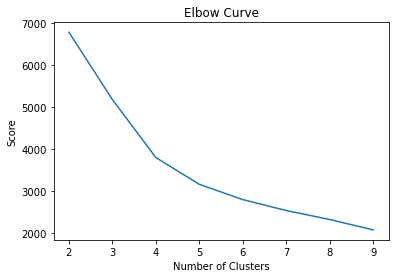

In [33]:
import numpy as np
import pandas as pd

cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(scaledData)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [98]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='features', k=4)
model = kmeans.fit(scaledData)

# Make predictions
predictions = model.transform(scaledData)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5322362165555465
Cluster Centers: 
[0.95895264 0.47322882 0.25908896]
[0.96022947 0.62511308 0.24019668]
[0.95926481 0.59128098 0.40162061]
[0.96070354 0.30939876 0.29762528]


In [99]:
predictions.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------+-------+--------------------+--------------------+--------------------+----------+
|         duration_ms|        danceability|            loudness|         speechiness|        acousticness|instrumentalness|liveness|valence|               tempo|      time_signature|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+--------+-------+--------------------+--------------------+--------------------+----------+
|[0.02718519496877...|[0.6074672048435923]|[0.8157886686245716]|[0.41606591143151...|[0.6606425702811246]|           [0.0]|[0.0972]| [0.65]|[0.7396227793539275]|[0.6000000000000001]|[0.97281480503638...|         3|
|[0.03858915312091...|[0.7769929364278506]|[0.8060144395496818]|[0.17713697219361...|[0.5451807228915664]|       [7.96E-4]|[0.0684]|[0.898]|